In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from itertools import product

from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


/home/psireal42/miniconda3/envs/mltutorial/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/psireal42/miniconda3/envs/mltutorial/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## Example using meshgrid

In [3]:
# Helper functions and dataclass
def split_data(x_full: np.ndarray,
               y_full: np.ndarray,
               train_fraction: float):
    """Generates three pytorch Datasets (full, train, test) given a set of features and labels."""

    # define fraction of data used for training
    assert x_full.shape[0] == y_full.shape[0]
    
    n_samples = y_full.shape[0]

    n_train = int(train_fraction * n_samples)

    # get indices for training and test set
    ids = np.arange(n_samples)
    np.random.shuffle(ids)
    ids_train, ids_test  = np.split(ids, [n_train])

    all_data = Data(x_full, y_full)
    train_data = Data(x_full[ids_train], y_full[ids_train])
    test_data = Data(x_full[ids_test], y_full[ids_test])

    return all_data, train_data, test_data

class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y).long().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index], self.y[index]
  
  def __len__(self) -> int:
    return self.len

## 1.1

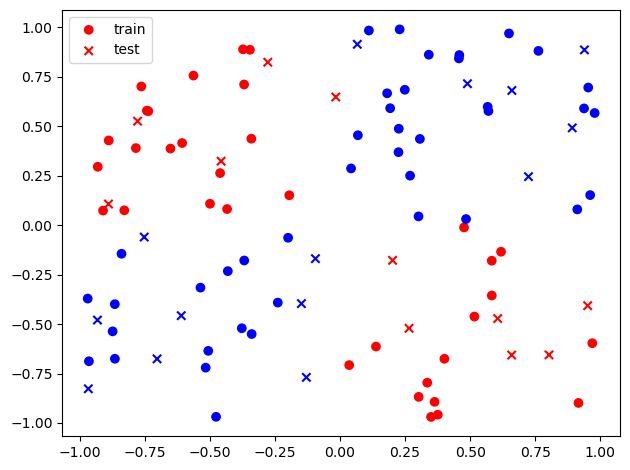

In [16]:
x = np.random.uniform(low = -1, high = 1, size = (100,2))
y = np.ones(100, dtype=int)*(x[:,0] * x[:,1]>0)

all_data, train_data, test_data = split_data(x,y,train_fraction=0.75)
color_map = ['blue' if i == 1 else 'red' for i in y]
fig, ax = plt.subplots()
ax.scatter(train_data.x[:,0], train_data.x[:,1], c=['blue' if i == 1 else 'red' for i in train_data.y], marker='o', label='train')
ax.scatter(test_data.x[:,0], test_data.x[:,1], c=['blue' if i == 1 else 'red' for i in test_data.y], marker='x', label='test')
plt.tight_layout()
plt.legend()
plt.show()

## 1.2

In [11]:
################################ NN class ################################
class MLPClassifier(nn.Module):
    def __init__(self, n_dims: list, activation= nn.ReLU(), return_proba=False):
        """
            Simple multi-layer perceptron (MLP) for classification.

            Parameters:
            -----------
            n_dims : List of integers specifying the dimensions of input and output and the hidden layers.
            activation: Activation function used for non-linearity. 
        """
        super().__init__()
        self.return_proba = return_proba

        # Get input and output dimensions
        dims_in = n_dims[:-1]
        dims_out = n_dims[1:]

        layers = []

        # Add linear layers (and activation function after all layers except the final one)
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            layers.append(torch.nn.Linear(dim_in, dim_out))
            
            if i < len(n_dims) - 2:
                layers.append(activation)
        

        self._layers = torch.nn.Sequential(*layers)
    

    def forward(self, x):
        """
        Forward pass for the MLP, optionally returning class probabilities.
        
        Parameters:
        -----------
        x : input data
        return_proba : whether to return raw logits or class probabilities
        """
        x = self._layers(x)
        if self.return_proba:
            x = nn.functional.softmax(x, dim=1)
        return x
   
    def count_parameters(self): 
        """
            Counts the number of trainable parameters.

        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class Trainer:

    def __init__(self, model:nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.modules.loss._Loss):
        self.model = model
        self.train_loader = train_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss = 0

    def train(self):            
        # Set model to training mode
        self.model.train()
        epoch_loss = 0
        n_batches = len(self.train_loader)

        # Loop over each batch from the training set
        for (data, target) in self.train_loader:
        
            # Copy data to GPU if needed
            data = data.to(DEVICE)
            target = target.to(DEVICE)

            # set optimizer to zero grad to remove previous gradients
            self.optimizer.zero_grad() 

            # Pass data through the network
            output = self.model(data)

            # Calculate loss
            loss = self.criterion(output, target)

            # get gradients
            loss.backward()
            
            # gradient descent
            self.optimizer.step()
            epoch_loss += loss.data.item()
        
        self.loss = epoch_loss / n_batches

    def evaluate_classification(self, test_loader: DataLoader) -> dict:
        
        """
            Evaluates a classification model by computing loss and classification accuray on a test set.

            Parameters:
            -----------
            model : pytorch model.
            test_loader : pytorch Dataloader containing the test data.
            criterion: Loss function. 

        """

        self.model.eval()
        
        val_loss, correct = 0, 0
        for data, target in test_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            val_loss += self.criterion(output, target).data.item()

            pred = output.data.max(1)[1] # get the index of the max probability
            correct += pred.eq(target.data).cpu().sum()

        val_loss /= len(test_loader)

        accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
        
        return {'loss': val_loss, 'accuracy': accuracy}

## 1.3

In [7]:
x = np.random.uniform(low = -1, high = 1, size = (100,2))
y = np.ones(100, dtype=int)*(x[:,0] * x[:,1]>0)

all_data, train_data, test_data = split_data(x,y,train_fraction=0.75)

learning_rate = 0.01
batch_size = 16
n_epochs = 1000
trainloader = DataLoader(train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
testloader = DataLoader(test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

no_of_hidden_layers = np.array([4,8])
no_of_nodes = np.arange(100, step=20) + 1

for NN in product(no_of_hidden_layers, no_of_nodes):
    dim_hidden_layers, dim_nodes = NN
    print(f'{dim_hidden_layers=}; {dim_nodes=}')
    # dim_in=2 <- (x1,x2); dim_out=2 <- {0,1}
    dimensions = [2] + [dim_nodes]*dim_hidden_layers + [2]
    model = MLPClassifier(n_dims=dimensions, activation=nn.ReLU()).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    trainer = Trainer(model, train_loader=trainloader, optimizer=optimizer, criterion=nn.CrossEntropyLoss())
    for epoch in range(n_epochs):
        trainer.train()

    loss, accuracy = trainer.evaluate_classification(test_loader=testloader).values()
    print(f'{loss=}; {accuracy=}')

dim_hidden_layers=4; dim_nodes=1
loss=0.6962266564369202; accuracy=tensor(36.)
dim_hidden_layers=4; dim_nodes=21
loss=0.008179976721294224; accuracy=tensor(100.)
dim_hidden_layers=4; dim_nodes=41
loss=0.02076447242870927; accuracy=tensor(100.)
dim_hidden_layers=4; dim_nodes=61
loss=0.006764401448890567; accuracy=tensor(100.)
dim_hidden_layers=4; dim_nodes=81
loss=0.01395748252980411; accuracy=tensor(100.)
dim_hidden_layers=8; dim_nodes=1
loss=0.6965433061122894; accuracy=tensor(36.)
dim_hidden_layers=8; dim_nodes=21
loss=0.6972952783107758; accuracy=tensor(36.)
dim_hidden_layers=8; dim_nodes=41
loss=0.6962735950946808; accuracy=tensor(36.)
dim_hidden_layers=8; dim_nodes=61
loss=0.6955600678920746; accuracy=tensor(36.)
dim_hidden_layers=8; dim_nodes=81
loss=0.6951015293598175; accuracy=tensor(36.)


How many layers and how many nodes per layer would you choose for a good classifier? <br>
A: dim_hidden_layers=4; dim_nodes=61

How many epochs do you need to train this network until convergence (have a look at how the accuracy evolves over time) ? <br>
A: Somehow the loss does not converge

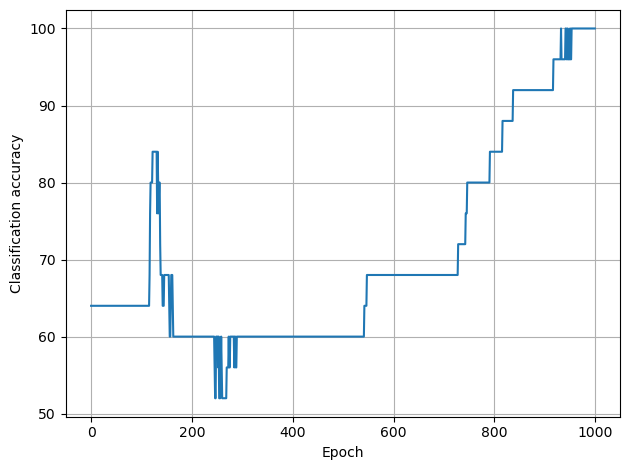

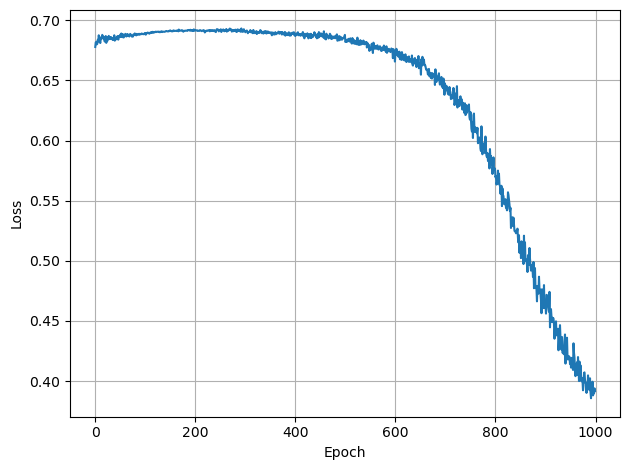

In [12]:
# Optimal NN
dim_hidden_layers = 4
dim_nodes=21
dimensions = [2] + [dim_nodes]*dim_hidden_layers + [2]

n_epochs = np.arange(1000)
loss_epochs = np.zeros(len(n_epochs))
class_accuracy = np.zeros(len(n_epochs))

model = MLPClassifier(n_dims=dimensions, activation=nn.ReLU(), return_proba=True).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
trainer = Trainer(model, train_loader=trainloader, optimizer=optimizer, criterion=nn.CrossEntropyLoss())

for epoch in n_epochs:
    trainer.train()
    loss, accuracy = trainer.evaluate_classification(test_loader=testloader).values()
    class_accuracy[epoch] = accuracy
    loss_epochs[epoch] = loss

plt.figure()
plt.plot(class_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.tight_layout()
plt.grid()
plt.show()

plt.figure()
plt.plot(loss_epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.grid()
plt.show()

Visualise the decision boundary in a filled contour plot (`plt.contourf`) with a red-blue colour map (RdBu) by creating a grid in x1 and x2 between [−1.1, 1.1] and a distance between grid points of h = 0.02 (using e.g. `np.meshgrid`) 

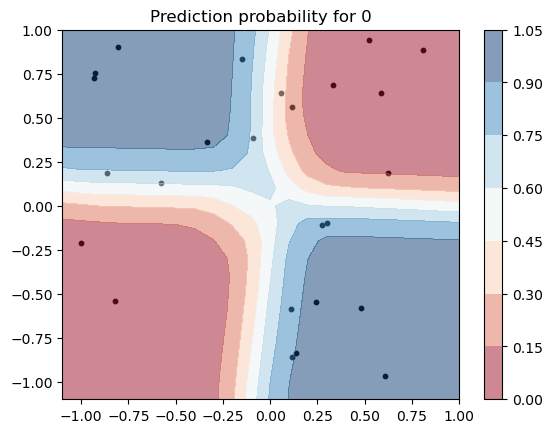

In [24]:
h = 0.1
x1 = np.arange(-1.1, 1.1, h)
x2 = np.arange(-1.1, 1.1, h)
xx1, xx2 = np.meshgrid(x1, x2)
x = np.c_[xx1.ravel(), xx2.ravel()]
x = torch.from_numpy(x).float().to(DEVICE)
y = model(x).detach().numpy()

# normalize y to lend a probabilistic interpretation
# y = y**2
# norms = np.linalg.norm(y, axis=1)
# y = y / norms[:, None]

y_0 = y[:,0].reshape(x1.size, x2.size) # prediction probability for 0
y_1 = y[:,1].reshape(x1.size, x2.size) # prediction probability for 1


fig,ax = plt.subplots()
ax.scatter(test_data.x[:,0], test_data.x[:,1], color='black', s=10)
contour_plot = ax.contourf(xx1,xx2,y_0, cmap='RdBu',alpha=0.5)
cbar = fig.colorbar(contour_plot)
plt.title('Prediction probability for 0')

plt.show()


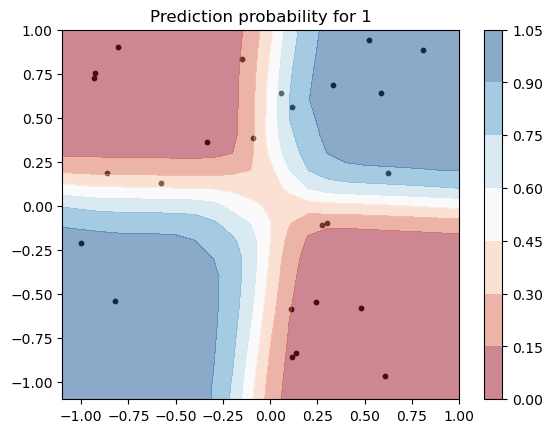

In [25]:
fig,ax = plt.subplots()
ax.scatter(test_data.x[:,0], test_data.x[:,1], color='black', s=10)
contour_plot = ax.contourf(xx1,xx2,y_1, cmap='RdBu', alpha=0.5)
cbar = fig.colorbar(contour_plot)
plt.title('Prediction probability for 1')
plt.show()

Evaluate the prediction probability for one of the two classes for all grid points.

Together with the decision boundary, plot the training and test dataset coloured according to their y-value. Compute and report the coefficient of determination ($R^2$) for the test dataset and the classification accuracy for the
training and test set.

# 2 - MNIST

### Loading the data

Now we want to use a common dataset in machine learning, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of hand-written digits. This is already contained in pytorch, so we don't need to generate it ourselfs and can just download it and store it in a DataLoader.

The dataset is contained in the torchvision package, which we can add to our environment using 

 conda install -c pytorch torchvision 

In [98]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [110]:
batch_size = 32

train_dataset_full = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

test_dataset_full = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

# The full dataset contains 60000 samples - this is too much for this Exercise. We therefore choose a subset of 1000 samples randomly chosen.
n_samples_train = 1000

 # get indices for training and test set
ids = np.arange(len(train_dataset_full))
np.random.shuffle(ids)
train_dataset = Subset(train_dataset_full, ids[:n_samples_train])

# get indices for training and test set
n_samples_test = 200
ids = np.arange(len(test_dataset_full))
np.random.shuffle(ids)
test_dataset = Subset(test_dataset_full, ids[:n_samples_test])

train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

print("The length of train data is:",len(train_dataset))
print("The length of test data is:",len(test_dataset))

The length of train data is: 1000
The length of test data is: 200


Let's have a look at a few samples from the training dataset.

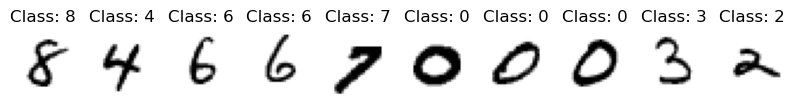

In [111]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i, idata in enumerate(train_dataset.indices[:10]):

    image = train_dataset.dataset[idata][0]
    label =  train_dataset.dataset[idata][1]
    
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(image.numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(label))



## 2.1

In [112]:
class MLPClassifierImages(MLPClassifier):
    def __init__(self, n_dims: list, activation = nn.ReLU(), flatten_input: bool = False):
        """
            Simple multi-layer perceptron (MLP) for classification of handwritten digits

            Parameters:
            -----------
            n_dims : List of integers specifying the dimensions of input and output and the hidden layers.
            activation: Activation function used for non-linearity. 
        """
        super().__init__(n_dims, activation)
        
        # If flatten_input is True, prepend a Flatten layer to self._layers
        if flatten_input:
            self._layers = nn.Sequential(nn.Flatten(), *self._layers)

In [116]:
no_of_hidden_layers = np.array([4,8])
no_of_nodes = np.arange(50, step=10) + 1
n_epochs = 1000

for NN in product(no_of_hidden_layers, no_of_nodes):
    dim_hidden_layers, dim_nodes = NN
    print(f'{dim_hidden_layers=}; {dim_nodes=}')
    # dim_in=28*28 <- (28x28 pixeös); dim_out=10 <- 10 digits
    dimensions = [28*28] + [dim_nodes]*dim_hidden_layers + [10]

    model = MLPClassifierImages(n_dims=dimensions, activation=nn.ReLU(), flatten_input=True).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    trainer = Trainer(model, train_loader=train_loader, optimizer=optimizer, criterion=nn.CrossEntropyLoss(), n_epochs=n_epochs)
    trainer.train()

    loss, accuracy = trainer.evaluate_classification(test_loader=test_loader).values()
    print(f'{loss=}; {accuracy=}')

dim_hidden_layers=4; dim_nodes=1
loss=2.305886779512678; accuracy=tensor(9.5000)
dim_hidden_layers=4; dim_nodes=11
loss=4.281667879649571; accuracy=tensor(79.)
dim_hidden_layers=4; dim_nodes=21
loss=2.9893900666918074; accuracy=tensor(80.)
dim_hidden_layers=4; dim_nodes=31
loss=2.3457576164177487; accuracy=tensor(81.5000)
dim_hidden_layers=4; dim_nodes=41
loss=1.4750120384352547; accuracy=tensor(85.5000)
dim_hidden_layers=8; dim_nodes=1
loss=2.3053026539938792; accuracy=tensor(9.5000)
dim_hidden_layers=8; dim_nodes=11
loss=2.3049954005650113; accuracy=tensor(9.5000)
dim_hidden_layers=8; dim_nodes=21
loss=2.43477554832186; accuracy=tensor(52.)
dim_hidden_layers=8; dim_nodes=31
loss=2.304328237261091; accuracy=tensor(9.5000)
dim_hidden_layers=8; dim_nodes=41
loss=3.7317369324820384; accuracy=tensor(76.)


1. Find a good NN architecture (number of layers, number of nodes per layer). For each
NN, determine the classification accuracy for the test and training datasets after a given
number of epochs and plot it as a function of your architecture.

    A: dim_hidden_layers=4; dim_nodes=41

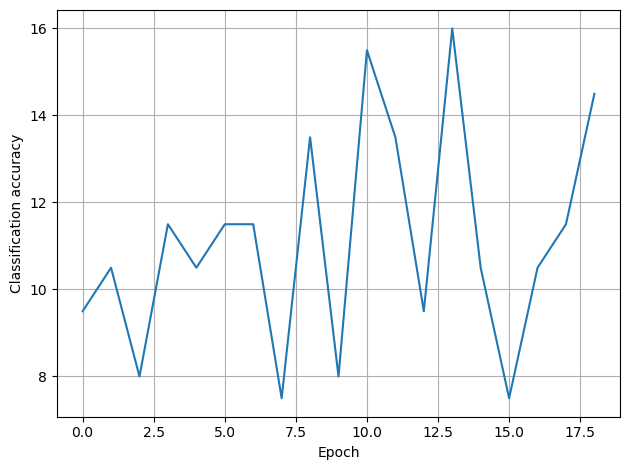

In [119]:
# Optimal NN
dim_hidden_layers = 4
dim_nodes=41
dimensions = [28*28] + [dim_nodes]*dim_hidden_layers + [10]
n_epochs = np.arange(1,20)
class_accuracy = np.zeros(len(n_epochs))

for n_epoch in n_epochs:
    model = MLPClassifierImages(n_dims=dimensions, activation=nn.ReLU(), flatten_input=True).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    trainer = Trainer(model, train_loader=train_loader, optimizer=optimizer, criterion=nn.CrossEntropyLoss(), n_epochs=n_epoch)
    trainer.train()
    loss, accuracy = trainer.evaluate_classification(test_loader=test_loader).values()
    class_accuracy[n_epoch - 1] = accuracy

plt.figure()
plt.plot(class_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.tight_layout()
plt.grid()
plt.show()

## 2.2

What are other advantages of using a CNN over an MLP for image classification?<br>
- CNNs use convolutional layers that apply filters to the input image. This means that the same filter (set of weights) is used across the entire image, significantly reducing the number of parameters compared to a fully connected MLP where each input is connected to each neuron in the next layer. This makes CNNs much more parameter efficient, especially for larger images.
- The max pooling layers (`nn.MaxPool2d`) in CNN reduce the spatial dimensions of the feature maps, making the network more robust to the translation and location of features within the image.
- By stacking multiple convolutional layers (see for-loop iteration through `no_of_blocks`), each followed by activation functions, CNN can learn a hierarchy of features. Lower layers might learn basic patterns, while deeper layers can combine these into more complex representations.

### 2.2.1

In [120]:
class CNN(nn.Module):
    def __init__(self, conv_blocks: dict, input_size: tuple, num_classes: int =10):
        """
        Initializes a convolutional neural network (CNN) with specified convolutional layers and output classes.

        Parameters:
        -----------
        conv_layers : Dictionary containing the parameters for a convolutional block:
                      (in_channels, out_channels, kernel_size, stride, padding).
        num_classes : The number of output classes. Defaults to 10 for digit classification.
        """
        super().__init__()
        
        self.conv_blocks = nn.ModuleList()
        # Initialize the convolutional blocks
        no_of_blocks = len(conv_blocks['in_channels']) 
        for i in range(no_of_blocks):
            conv_block = nn.Sequential(
                nn.Conv2d(conv_blocks['in_channels'][i], 
                          conv_blocks['out_channels'][i], 
                          conv_blocks['kernel_size'][i], 
                          conv_blocks['stride'][i], 
                          conv_blocks['padding'][i]),
                nn.ReLU(),
                nn.MaxPool2d(conv_blocks['pool_kernel_size'][i], 
                             conv_blocks['pool_stride'][i])
            )
            self.conv_blocks.append(conv_block)
            
        self.flatten_size = self._calculate_flatten_size(input_size, conv_blocks)
        
        
        self.linear_layer = nn.Linear(in_features=self.flatten_size, out_features=num_classes)


    def forward(self, x):
        
        for block in self.conv_blocks:
            x = block(x)
        
        # before passing output of the last conv_block to the linear layer, the output must be flattened
        x = x.view(x.size(0), -1)
        x = self.linear_layer(x)
        
        return F.softmax(x, dim=1)
    
    
    def _calculate_flatten_size(self, input_size, conv_blocks):
        """
        Calculate the size of the tensor before the linear layer
        based on the convolution and pooling layers' parameters for a fully connected network
        """
        # Start with the initial size (height, width) of the input image
        current_size = input_size

        # Iterate through each block to calculate the output size
        for i in range(len(conv_blocks['in_channels'])):
            # Apply the convolution layer transformations
            current_size = (
                (current_size[0] - conv_blocks['kernel_size'][i] + 2 * conv_blocks['padding'][i]) // conv_blocks['stride'][i] + 1,
                (current_size[1] - conv_blocks['kernel_size'][i] + 2 * conv_blocks['padding'][i]) // conv_blocks['stride'][i] + 1
            )

            # Apply the max pooling layer transformations
            current_size = (
                (current_size[0] - conv_blocks['pool_kernel_size'][i]) // conv_blocks['pool_stride'][i] + 1,
                (current_size[1] - conv_blocks['pool_kernel_size'][i]) // conv_blocks['pool_stride'][i] + 1
            )

        # The final size of the feature map will be the product of the
        # current dimensions and the number of output channels of the last conv layer
        final_num_features = current_size[0] * current_size[1] * conv_blocks['out_channels'][-1]
        return final_num_features

In [121]:
conv_blocks = {'in_channels': [1,16], 'out_channels': [16,32], 'kernel_size': [5,5], 'stride': [1,1], 'padding': [2,2], 'pool_kernel_size': [2,2], 'pool_stride': [2,2]}
_, width, height = train_dataset_full.data.size()
n_epochs = 5
model = CNN(conv_blocks=conv_blocks, input_size=(width, height))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
trainer = Trainer(model, train_loader=train_loader, optimizer=optimizer, criterion=nn.CrossEntropyLoss(), n_epochs=n_epochs)
trainer.train()
loss, accuracy = trainer.evaluate_classification(test_loader=test_loader).values()
print(f'{loss=}; {accuracy=}')


loss=2.30073424748012; accuracy=tensor(14.)


### 2.2.2